# Math 124 - Programming for Mathematical Applications
UC Berkeley, Spring 2024

## Project 2 - Random Maze
Due Friday, March 1

### Description

In this project, you will write a computer code to generate a random maze using a recursive algorithm. You will also write a code to find a path between two points in a given maze.

The integer `n` specifies the size of the `n`-by-`n` array of cells in the maze. Note the matrix indices `i,j` specify the $x$ and $y$-coordinates, respectively (see plot below).

The horizontal and the vertical *interior* walls of the maze are described by the arrays:

- `H`, Bool array of size `n`-by-`n-1`
- `V`, Bool array of size `n-1`-by-`n`

These arrays specify if there is a wall or not between two neighboring cells.

An example is given below, with $n=6$:

In [8]:
H = Bool[0 1 0 0 0; 1 0 1 0 0; 0 1 1 0 0; 1 1 1 0 1; 0 1 0 1 1; 1 0 0 0 0];
V = Bool[1 0 1 1 1 0; 0 1 0 0 1 1; 0 0 0 0 1 0; 0 1 0 1 0 0; 0 0 1 0 1 0];

and the following helper functions can be used to plot the maze:

In [6]:
using PyPlot, Random

function plot_maze(H,V)
    clf()
    axis("off")
    axis("equal")
    n = size(H,1)
    plot([0,n,n,0,0], [0,0,n,n,0], color="k")
    
    for x = 1:n-1, y = 1:n
        if V[x,y]
            plot([x,x], [y-1,y], color="k")
        end
    end
    for x = 1:n, y = 1:n-1
        if H[x,y]
            plot([x-1,x], [y,y], color="k")
        end
    end
end

function plot_cell_indices(n)
    for i = 1:n
        for j = 1:n
            text(i-0.5, j-0.5, "($i,$j)",
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=8)
        end
    end
end

[ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]


plot_cell_indices (generic function with 1 method)

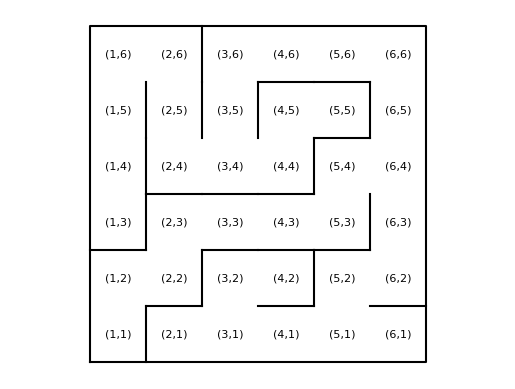

In [9]:
plot_maze(H,V)
plot_cell_indices(size(H,1))

In addition, we will find paths between the points `1,n` and `n,1`, which can be stored in two arrays of integers. For the example above, this path is given by

In [10]:
x = [6, 5, 5, 6, 6, 6, 6, 6, 5, 4, 3, 3, 3, 2, 2, 2, 1];
y = [1, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 5, 4, 4, 5, 6, 6];

and it can be plotted along with the maze using the commands:

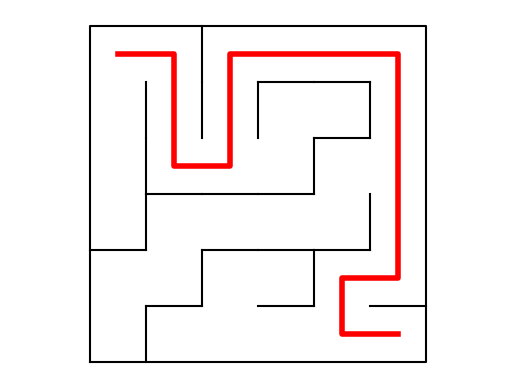

In [11]:
plot_maze(H,V);
plot(x .- 0.5, y .- 0.5, color="r", linewidth=4);

### Problem 1 - Generate random maze

Write a function with the syntax

```julia
H,V = make_maze(n)
```

which produces a random maze of size `n`-by-`n` using the following algorithm:

1. Initialize `H` and `V` to matrices of `trues` (that is, assume all cells have walls on all sides)
2. Also initialize an array `visit` to a matrix of `falses`, to keep track of cells that have been visited
3. Create a function `dig(x,y)` which loops over the four directions (Right, Left, Up, Down) in a random order. For each direction, if the neighbor cell is valid and not visited, remove the corresponding wall from `H` or `V` and run the `dig` function recursively on the neighbor cell.
4. Call `dig(1,1)` and return `H,V`

In [36]:
function make_maze(n)
    H = trues(n,n-1)
    V = trues(n-1,n)
    visit = falses(n,n)

    function dig(x,y)
        visit[x, y] = true
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        
        for i in 2:4
            j = rand(1:i)
            directions[i], directions[j] = directions[j], directions[i]
        end
        for (dx, dy) in directions
            nx, ny = x + dx, y + dy
            if 1 ≤ nx ≤ n && 1 ≤ ny ≤ n && !visit[nx, ny] # inside the maze and not visited
                if dx == 0 
                    if dy == 1
                        H[x, y] = false
                    else
                        H[x, y-1] = false
                    end
                else
                    if dx == 1
                        V[x, y] = false
                    else
                        V[x-1, y] = false
                    end
                end
                dig(nx, ny)
            end
        end
    end
    dig(1, 1) # start from top left
    return H, V
end

make_maze (generic function with 1 method)

### Problem 2 - Find path from `1,n` to `n,1`

Next, write a function with the syntax

```julia
pathx, pathy = find_path(H,V)
```

which finds a path in the maze `H,V` between the coordinates `1,n` and `n,1` using the following algorithm:

1. Again create an array `visit` to keep track of visited cells
2. Also initialize empty vectors `pathx,pathy` to store the final path
3. Create a recursive function `recur(x,y)` which performs the following:
   1. If the position `x==n` and `y==1` is found, insert these values into `pathx,pathy` and return `true`
   2. Otherwise, consider each neighbor of `x,y`. If the cell is valid, the maze has no wall in that direction, and the cell has not been visited, apply `recur` to the neighbor cell.
   3. If any of the calls to `recur` returns `true`, insert `x,y` into `pathx,pathy` and return `true`
4. Call `recur(1,n)` and return `pathx,path`

In [37]:
function find_path(H, V)
    n = size(H, 1)
    visit = falses(n, n)
    path_x = []
    path_y = []
    function recur(x, y) 
        if x == n && y == 1
            pushfirst!(path_x, x)
            pushfirst!(path_y, y)
            return true
        end
        visit[x, y] = true
        nb = [(x, y+1), (x, y-1), (x+1, y), (x-1, y)]
        
        for (nx, ny) in nb
            if 1 ≤ nx ≤ n && 1 ≤ ny ≤ n && !visit[nx, ny]
                if nx == x
                    if ny > y && !H[x, y] #move right
                        if recur(nx, ny)
                            pushfirst!(path_x, x)
                            pushfirst!(path_y, y)
                            return true
                        end
                    elseif ny < y && !H[x, y-1]  # move left
                        if recur(nx, ny)
                            pushfirst!(path_x, x)
                            pushfirst!(path_y, y)
                            return true
                        end
                    end
                elseif ny == y 
                    if nx > x && !V[x, y]  # move down
                        if recur(nx, ny)
                            pushfirst!(path_x, x)
                            pushfirst!(path_y, y)
                            return true
                        end
                    elseif nx < x && !V[x-1, y]  # move up
                        if recur(nx, ny)
                            pushfirst!(path_x, x)
                            pushfirst!(path_y, y)
                            return true
                        end
                    end
                end
            end
        end
        return false
    end
    recur(1, n)
    return path_x, path_y
end

find_path (generic function with 1 method)

### Problem 3 - Large maze test

Finally, run the code below to illustrate your codes.

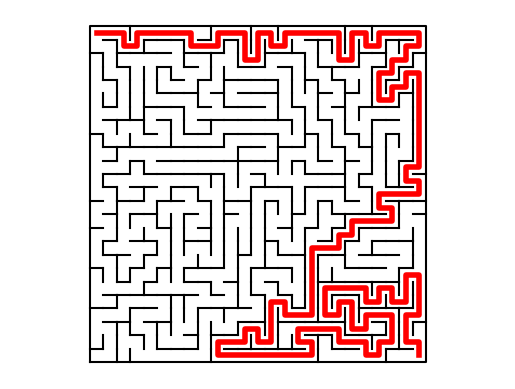

In [38]:
n = 25
H,V = make_maze(n)
plot_maze(H,V)
x, y = find_path(H,V)
plot(x .- 0.5, y .- 0.5, color="r", linewidth=4);